In [74]:
import numpy as np
import theano.tensor as tt
from theano import shared
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import pymc3 as pm
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

RANDOM_SEED = 2023
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-ticks')

In [75]:
def hbm_vary_intercepts_slopes_model(train_index, test_index, selected_df, selected_names, individual_names):

    group_num = len(selected_df.group.unique())

    x_train, x_test = selected_df.loc[train_index, :], selected_df.loc[test_index, :]
    y_train, y_test = selected_df.loc[train_index,'y_real'], selected_df.loc[test_index,'y_real']

    group_level_variables = np.zeros((group_num,1))
    for group_idx in range(group_num):
        group_level_variables[group_idx,0] = x_train.loc[x_train.group == group_idx, 'g'].mean()
    
    g_transformer = StandardScaler()
    group_level_variables = g_transformer.fit_transform(group_level_variables)

    # Standard Scaler
    transformer = StandardScaler()
    processed_x_train = transformer.fit_transform(x_train.loc[:,individual_names])
    processed_x_test = transformer.transform(x_test.loc[:,individual_names])

    with pm.Model() as hierarchical_model:
        data = pm.Data('data', processed_x_train)
        group_data = pm.Data('group_data', group_level_variables)

        raw_group_ind = x_train.loc[:,'group'].values
        raw_group_ind = raw_group_ind.astype(int)
        group_ind = pm.Data('group_ind',np.asarray(raw_group_ind))

        g_intercept = pm.Normal('g_intercept', mu = 3.2, sigma=10) # hyperprior intercept
        g = pm.Normal('g', mu = 0, sigma = 10) 
        offset_intercept = pm.Normal('offset_intercept', mu=0, sigma=3.0, shape = group_num)
        mu_intercept = g_intercept + g * group_data[:,0] 
        sigma_intercept = pm.Exponential('sigma_intercept', 1.0)
        intercept = pm.Deterministic('intercept', mu_intercept + offset_intercept * sigma_intercept)
        
        g_slope0 = pm.Normal('g_slope0', mu = 0, sigma = 10) # hyperprior slope0
        g_slope0_intercept = pm.Normal('g_slope0_intercept', mu = 0, sigma=10)
        sigma_a_slope0 = pm.Exponential('sigma_a_slope0', 1.0)
        mu_slope0 = g_slope0_intercept + g_slope0 * group_data[:,0] 
        offset_0 = pm.Normal('offset_0', mu= 0, sigma= 3.0, shape = group_num)
        slope_0 = pm.Deterministic('slope_0', mu_slope0 + offset_0 * sigma_a_slope0)

        g_slope1 = pm.Normal('g_slope1', mu = 0, sigma = 10) # hyperprior slope1
        g_slope1_intercept = pm.Normal('g_slope1_intercept', mu = 0, sigma=10)
        sigma_a_slope1 = pm.Exponential('sigma_a_slope1', 1.0)
        mu_slope1 = g_slope1_intercept + g_slope1 * group_data[:,0] 
        offset_1 = pm.Normal('offset_1', mu= 0, sigma= 3.0, shape = group_num)
        slope_1 = pm.Deterministic('slope_1', mu_slope1 + offset_1 * sigma_a_slope1)

        g_slope2 = pm.Normal('g_slope2', mu = 0, sigma = 10) # hyperprior slope2
        g_slope2_intercept = pm.Normal('g_slope2_intercept', mu = 0, sigma=10)
        sigma_a_slope2 = pm.Exponential('sigma_a_slope2', 1)
        mu_slope2 = g_slope2_intercept + g_slope2 * group_data[:,0] 
        offset_2 = pm.Normal('offset_2', mu= 0, sigma= 3.0, shape = group_num)
        slope_2 = pm.Deterministic('slope_2', mu_slope2 + offset_2 * sigma_a_slope2)

        noise = pm.Exponential('noise', 1.0)
        y_est = intercept[group_ind] + slope_0[group_ind] * data[:,0] + slope_1[group_ind] * data[:,1] + slope_2[group_ind] * data[:,2]
        
        likelihood = pm.Normal('y_like', mu=y_est, sigma=noise, observed=y_train.values)
        hierarchical_trace = pm.sample(2000,tune=2000,target_accept=0.99,return_inferencedata=False)

    curr_waic = az.waic(hierarchical_trace, hierarchical_model, scale='deviance')

    with hierarchical_model:
        all_test = processed_x_test
        all_labels = y_test.values

        raw_group_ind = x_test.loc[:,'group'].values
        raw_group_ind = raw_group_ind.astype(int)

        pm.set_data({'data': all_test}, model=hierarchical_model)
        pm.set_data({'group_ind': np.asarray(raw_group_ind)}, model=hierarchical_model)

        all_posterior_samples = pm.sample_posterior_predictive(hierarchical_trace)
        all_pred = all_posterior_samples["y_like"].mean(axis=0)

        # tol_mpe_hierarchical = mean_absolute_percentage_error(y_true = all_labels, 
        #                                     y_pred = all_pred)
        # tol_rmse_hierarchical = mean_squared_error(y_true= all_labels, 
        #                                     y_pred = all_pred, squared=False)

        tol_mpe_hierarchical = mean_absolute_percentage_error(y_true=np.exp(all_labels), 
                                            y_pred =np.exp(all_pred))
        tol_rmse_hierarchical = mean_squared_error(y_true=np.exp(all_labels), 
                                            y_pred =np.exp(all_pred), squared=False)
                                            
    return [tol_rmse_hierarchical, tol_mpe_hierarchical, curr_waic, all_pred, hierarchical_trace]

In [77]:
raw_df = pd.read_csv('combine_feat_g8_origin_table.csv')

data_df = pd.DataFrame()
data_df['x1'] = np.log(-raw_df.min_cyc.values)
data_df['x2'] = np.log(raw_df.var_cyc.values)
data_df['x3'] = np.log(raw_df.skew_cyc.values+1)
data_df['x4'] = np.log(raw_df.kurt_cyc.values)
data_df['x5'] =raw_df.initial_Q.values
data_df['x6'] =raw_df.max_Q.values - raw_df.initial_Q.values
data_df['g'] = raw_df.g
data_df['group'] = raw_df.group
# data_df['y_real'] = np.log(raw_df.EoL_cycle)
data_df['y_real'] = np.log(raw_df.EoL_time)


In [79]:
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
rmse_ridge_list = list()
mpe_ridge_list = list()
iter_times = 4
sss = RepeatedStratifiedKFold(n_splits=5, n_repeats=iter_times, random_state=RANDOM_SEED)
# sss = StratifiedShuffleSplit(n_splits=iter_times, test_size=0.2, random_state=RANDOM_SEED)

# kf.get_n_splits()
sss.get_n_splits()
for train_index, test_index in sss.split(data_df, data_df.group.values):
    ridge_model = Ridge(alpha=1)
    train_x = data_df.loc[train_index,['x1','x2','x3','x4','x5','x6']].values
    train_y = data_df.loc[train_index,'y_real'].values.reshape(-1,1)

    stand = StandardScaler()
    train_x_stand = stand.fit_transform(train_x)

    test_x = data_df.loc[test_index,['x1','x2','x3','x4','x5','x6']].values
    test_y = data_df.loc[test_index,'y_real'].values.reshape(-1,1)
    test_x_stand = stand.transform(test_x)

    ridge_model.fit(train_x_stand,train_y)
    ypred = ridge_model.predict(test_x_stand)
    curr_rmse = mean_squared_error(y_true=np.exp(test_y), y_pred =np.exp(ypred), squared=False)
    curr_mpe = mean_absolute_percentage_error(y_true=np.exp(test_y), y_pred =np.exp(ypred))

    rmse_ridge_list.append(curr_rmse)
    mpe_ridge_list.append(curr_mpe)
rmse_ridge_list = np.asarray(rmse_ridge_list)
mpe_ridge_list = np.asarray(mpe_ridge_list)

display(np.mean(rmse_ridge_list))
display(np.mean(mpe_ridge_list))

3.722380084500311

0.10014815452499237

In [67]:
from arviz import plot_posterior
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
selected_names = ['g','x1','x2','x5']
individual_names = ['x1','x2','x5']
iter_times = 4
# sss = StratifiedShuffleSplit(n_splits=iter_times, test_size=0.2, random_state=123)
sss = RepeatedStratifiedKFold(n_splits=5, n_repeats=iter_times, random_state=RANDOM_SEED)
sss.get_n_splits()

rmse_hbm = list()
mpe_hbm= list()

ind = 0
for train_index, test_index in sss.split(data_df, data_df.group.values):
    curr_rmse_hbm, curr_mpe_hbm, curr_waic_hbm, pred_hbm, posterior_hbm = hbm_vary_intercepts_slopes_model(train_index, test_index, data_df, selected_names, individual_names)
    rmse_hbm.append(curr_rmse_hbm)
    mpe_hbm.append(curr_mpe_hbm)
    print('finished ', ind)
    ind = ind + 1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 130 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 167 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 170 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 215 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 130 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 124 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 122 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 232 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 143 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 147 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 192 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 201 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 133 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 122 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 165 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 192 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 176 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 138 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 143 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, offset_2, sigma_a_slope2, g_slope2_intercept, g_slope2, offset_1, sigma_a_slope1, g_slope1_intercept, g_slope1, offset_0, sigma_a_slope0, g_slope0_intercept, g_slope0, sigma_intercept, offset_intercept, g, g_intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 118 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


finished  19


In [68]:
display(np.mean(rmse_hbm))
display(np.mean(mpe_hbm))

3.2989227579981653

0.09224997432174181

c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sann7383\Anaconda3\envs\pymc_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


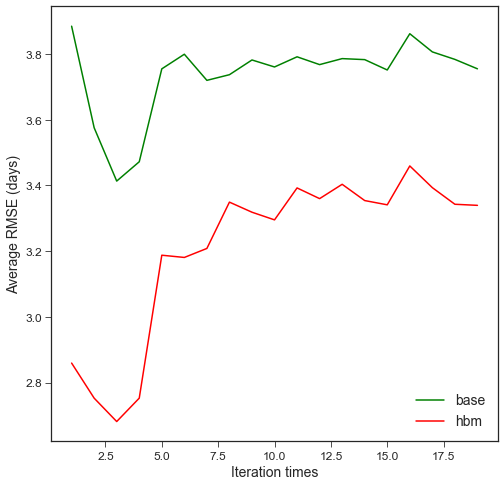

In [81]:
fig = plt.figure(figsize=(8,8))
L = len(rmse_hbm)
rmse_mean_hbm = np.zeros((L,1))
rmse_mean_base = np.zeros((L,1))
mpe_mean_hbm = np.zeros((L,1))
mpe_mean_base = np.zeros((L,1))

for i in range(L):
    rmse_mean_hbm[i] = np.mean(rmse_hbm[:i])
    rmse_mean_base[i] = np.mean(rmse_ridge_list[:i])
    mpe_mean_hbm[i] = np.mean(mpe_hbm[:i])
    mpe_mean_base[i] = np.mean(mpe_ridge_list[:i])

plt.plot(np.arange(L), rmse_mean_base, 'g', label='base')
plt.plot(np.arange(L), rmse_mean_hbm, 'r', label='hbm')


plt.xlabel('Iteration times',fontsize=14)
plt.xticks(fontsize = 12)
# plt.xlim(-1,51)
# plt.ylim(3.1,4.7)
plt.ylabel('Average RMSE (days)', fontsize=14)
plt.yticks(fontsize = 12)
plt.legend(fontsize=14)
plt.show()

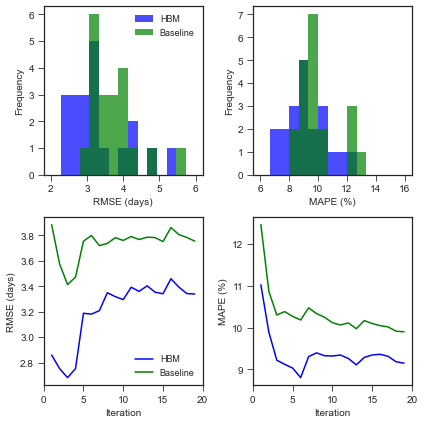

In [82]:
fig, axs=plt.subplots(2,2,figsize=(6,6))
# axs[1].grid(None)
bins_rmse = np.linspace(2, 6, 16)
axs[0,0].hist(rmse_hbm, bins = bins_rmse, alpha=0.7, color='b', label='HBM')
axs[0,0].hist(rmse_ridge_list, bins= bins_rmse, alpha=0.7, color='g', label='Baseline')
axs[0,0].set_xticks([2,3,4,5,6])
axs[0,0].set_xlabel('RMSE (days)')
axs[0,0].set_ylabel('Frequency')

axs[0,0].legend(fontsize=9)

bins_mpe = np.linspace(6, 16, 16)
axs[0,1].hist(100*np.array(mpe_hbm), bins=bins_mpe, alpha=0.7,color='b')
axs[0,1].hist(100*mpe_ridge_list, bins=bins_mpe, alpha=0.7,color='g')
axs[0,1].set_xticks([6,8,10,12,14,16])
axs[0,1].set_xlabel('MAPE (%)')
axs[0,1].set_ylabel('Frequency')


axs[1,0].plot(np.arange(L), rmse_mean_hbm, 'b', label='HBM')
axs[1,0].plot(np.arange(L), rmse_mean_base, 'g', label='Baseline')
axs[1,0].set_xticks([0,5,10,15,20])
axs[1,0].set_xlabel('Iteration')
axs[1,0].set_ylabel('RMSE (days)')
axs[1,0].legend(fontsize=9)

axs[1,1].plot(np.arange(L), 100*np.array(mpe_mean_hbm), 'b', label='HBM')
axs[1,1].plot(np.arange(L), 100*np.array(mpe_mean_base), 'g', label='Baseline')
axs[1,1].set_xticks([0,5,10,15,20])
axs[1,1].set_xlabel('Iteration')
axs[1,1].set_ylabel('MAPE (%)')

plt.tight_layout()